In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# Exercise 7: Clustering

## Task 1: Conceptual Questions

In [9]:
df = pd.read_csv("Mall_Customers.csv")
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [10]:
# ...

## Task 2: K-Means Clustering

### Data Preprocessing
Note that Gender is a categorical variable. We need to convert it to a numerical variable before we can use it in our clustering algorithm. CustomerID is not useful for clustering, so we can drop it.

Moreover, we need to scale the data before applying K-Means clustering, because otherwise the algorithm will ignore the variable with the lower range like gender.

In [11]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

proc_df = df.drop('CustomerID', axis=1)
proc_df['Gender'] = LabelEncoder().fit_transform(proc_df['Gender'])
proc_df = StandardScaler().fit_transform(proc_df)

In [12]:
proc_df[:5]

array([[ 1.12815215, -1.42456879, -1.73899919, -0.43480148],
       [ 1.12815215, -1.28103541, -1.73899919,  1.19570407],
       [-0.88640526, -1.3528021 , -1.70082976, -1.71591298],
       [-0.88640526, -1.13750203, -1.70082976,  1.04041783],
       [-0.88640526, -0.56336851, -1.66266033, -0.39597992]])

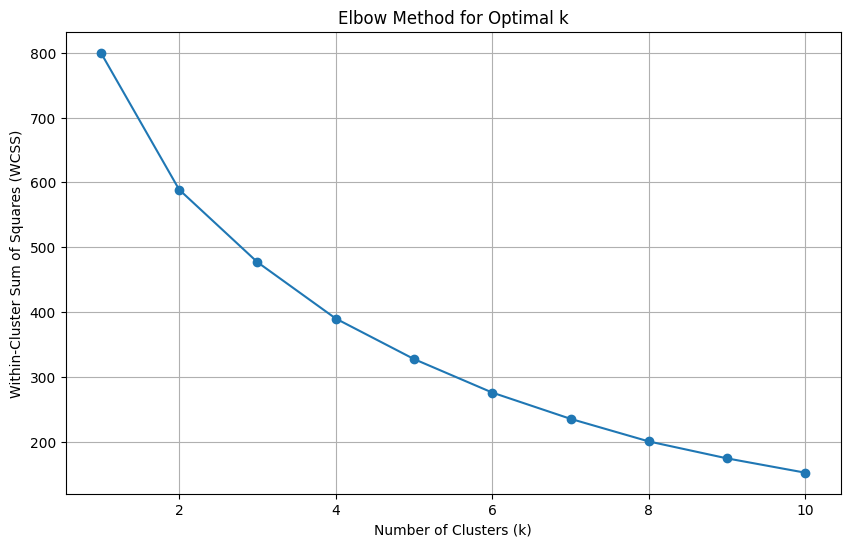

In [13]:
from sklearn.cluster import KMeans

def calculate_wcss(df, centers, labels):
    wcss = 0
    for i in range(len(centers)):
        cluster_points = df[labels == i]
        center = centers[i]
        wcss += np.sum((cluster_points - center) ** 2)
    return wcss


def kmeans_wccs(df, max_clusters=10):
    wcss = []
    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=6, init='random') # init='random' for consistency with R
        kmeans.fit(df)
        # wcss.append(kmeans.inertia_)  # are we allowed to use this?
        wcss.append(calculate_wcss(df, kmeans.cluster_centers_, kmeans.labels_))
    return wcss

wcss = kmeans_wccs(proc_df)

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(wcss) + 1), wcss, marker='o')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.show()

In [14]:
def find_elbow_point(wcss):
    differences = np.diff(wcss)
    rate_of_change = np.diff(differences)
    return np.argmax(np.abs(rate_of_change)) + 2

optimal_clusters = find_elbow_point(wcss)
print(f"Optimal number of clusters according to elbow method: {optimal_clusters}")

Optimal number of clusters according to elbow method: 2


We see the WCCS decreases gradually, elbow point is not very clear. But formally, k=2 as the max rate of change.

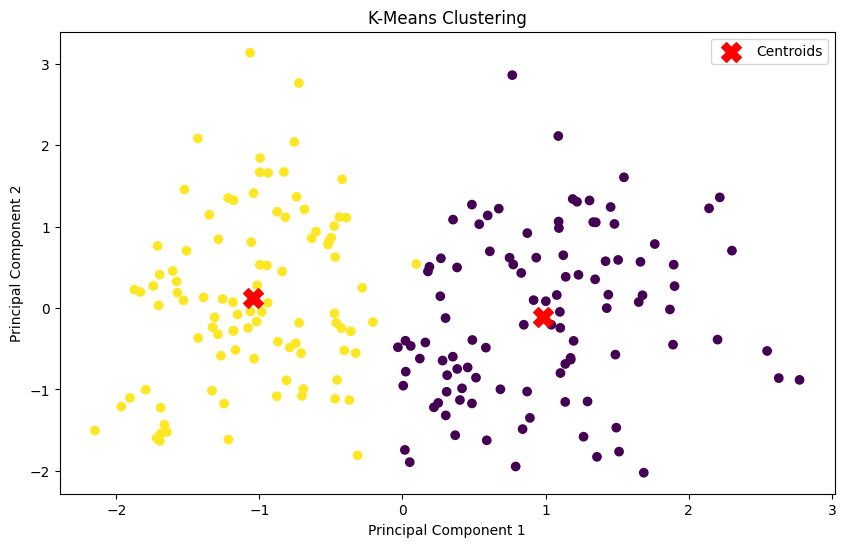

In [15]:
from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=optimal_clusters, random_state=6, init='random')
kmeans.fit(proc_df)

pca = PCA(n_components=2)
pca_df = pca.fit_transform(proc_df)

plt.figure(figsize=(10, 6))
plt.scatter(pca_df[:, 0], pca_df[:, 1], c=kmeans.labels_, cmap='viridis')
pca_centers = pca.transform(kmeans.cluster_centers_)
plt.scatter(pca_centers[:, 0], pca_centers[:, 1], marker='X', s=200, c='red', label='Centroids')
plt.legend()
plt.title('K-Means Clustering')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')

plt.show()

Having embedded the data into a 2D space, we can see that the data points are clustered into 2 groups. The K-Means algorithm has successfully identified the clusters.
Now let's analyze the clusters by looking at the distribution of the numerical features.

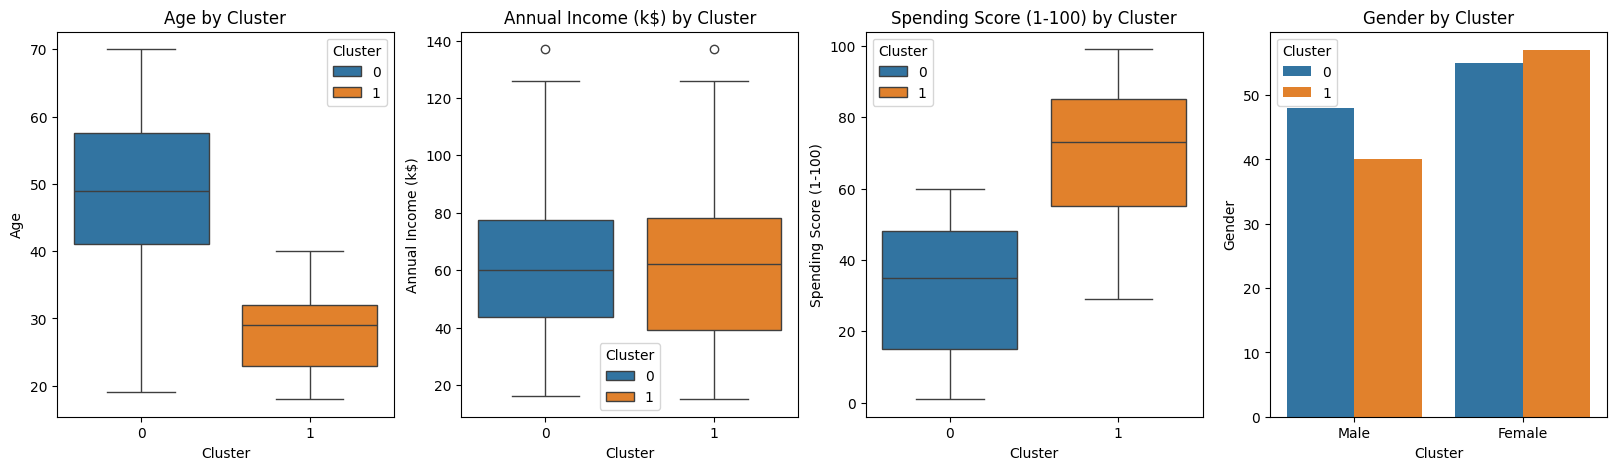

In [16]:
numeric_columns = ['Age', 'Annual Income (k$)', 'Spending Score (1-100)', 'Gender']

labeled_df = df.copy()
labeled_df['Cluster'] = kmeans.labels_

fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for ax, col in zip(axs, numeric_columns):
    if col == 'Gender':
        sns.countplot(x=col, hue='Cluster', data=labeled_df, ax=ax)
    else:
        sns.boxplot(x='Cluster', y=col, hue='Cluster', data=labeled_df, ax=ax)
    ax.set_title(f'{col} by Cluster')
    ax.set_xlabel('Cluster')
    ax.set_ylabel(col)

We can see that annual income distribution is almost the same for both clusters. The first cluster has a higher number of males compared to the second cluster, but the difference is not extreme.

However, the spending score and age distributions are very different (IQRs don't overlap). The first cluster has a lower spending score and a higher age compared to the second cluster. Let's visualize the data points in the 2D space with respect to age and spending score.

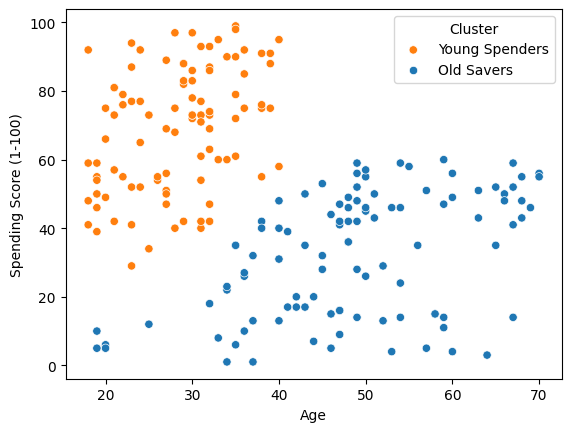

In [17]:
sns.scatterplot(x='Age', y='Spending Score (1-100)', hue='Cluster', data=labeled_df)
plt.legend(title='Cluster', labels=['Young Spenders', 'Old Savers'])

Indeed we can see that the clusters are separated by the spending score and age.

The first cluster corresponds to the young individuals with high spending scores. The second cluster corresponds to the older individuals with lower spending scores.

## Task 3: Hierarchical Clustering

3. Hierarchical Clustering

(a) Use the Dendrogram to ﬁnd the optimal number of clusters. Create a dendrogram with
the hclust() function and the Euclidean method.
Besides the Euclidean distance there is also the Mahalanobis Distance. Describe in easy
words the diﬀerence between those two distances.

(b) What are the optimal number of clusters according to the dendrogram method and why?

(c) Fit the hierarchical cluster to the mall dataset with the hclust() an cutree() function.

(d) Visualize the hierarchical clusters again with the clusplot() function from the cluster
library.

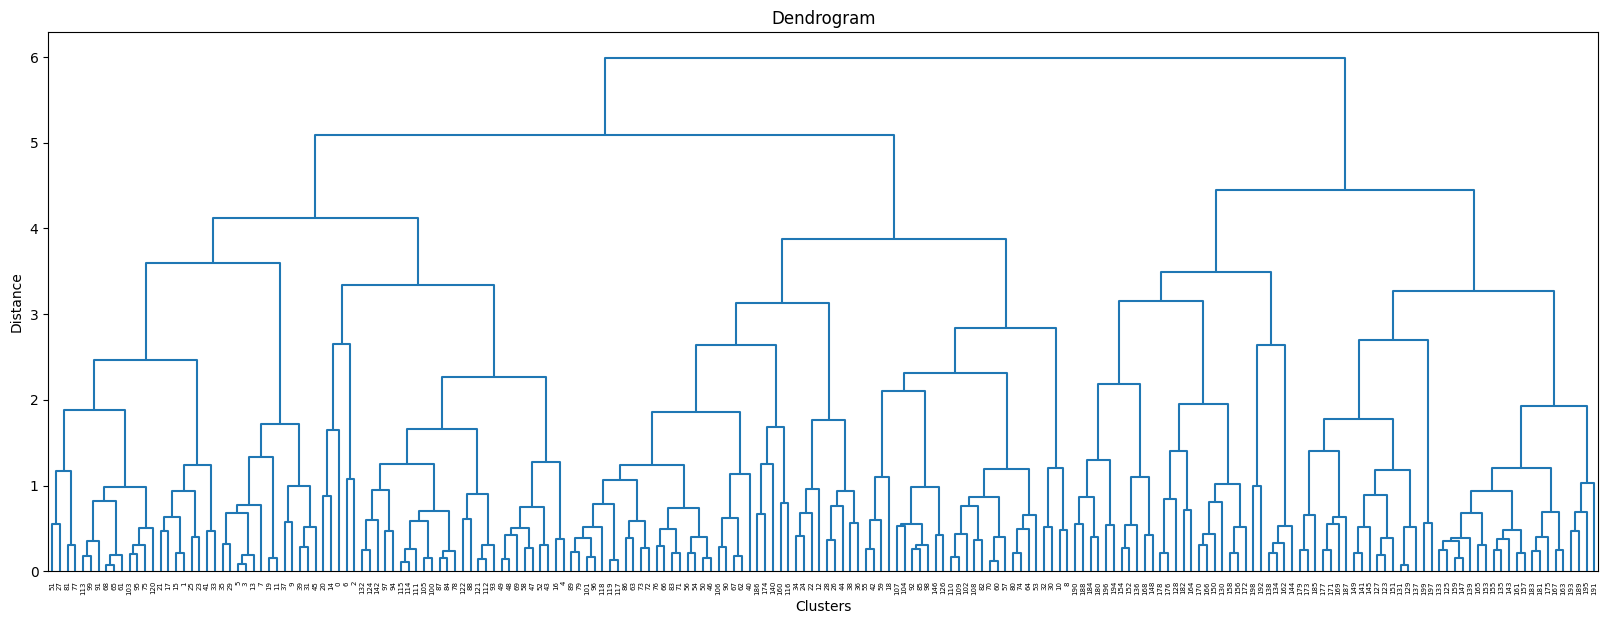

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

linked = linkage(proc_df, method='complete')

plt.figure(figsize=(20, 7))
dendrogram(linked,
           truncate_mode=None,
            orientation='top',
            distance_sort='descending',
            color_threshold=0,
            show_leaf_counts=True)
plt.title('Dendrogram')
plt.xlabel('Clusters')
plt.ylabel('Distance')
plt.show()

(a) the difference between Mahalanobis Distance and Euclidian is that Mahalanobis distance takes into account the possible correlations in features while euclidien not and tries to decorrelate features for proper distances

(b) I think the most significant 'gap' in dissimilarities is on the top right corner of the dendrogram. This means that the distance between clusters is too big. So we will cut at 4.9 distance and will have 3 clusters

In [19]:
from sklearn.cluster import AgglomerativeClustering
n_clusters = 3  # Define the optimal number of clusters based on the dendrogram
hc = AgglomerativeClustering(n_clusters=n_clusters, metric='euclidean', linkage='complete')
y_hc = hc.fit_predict(proc_df)

df['Cluster'] = y_hc  # Add the cluster column to the dataframe


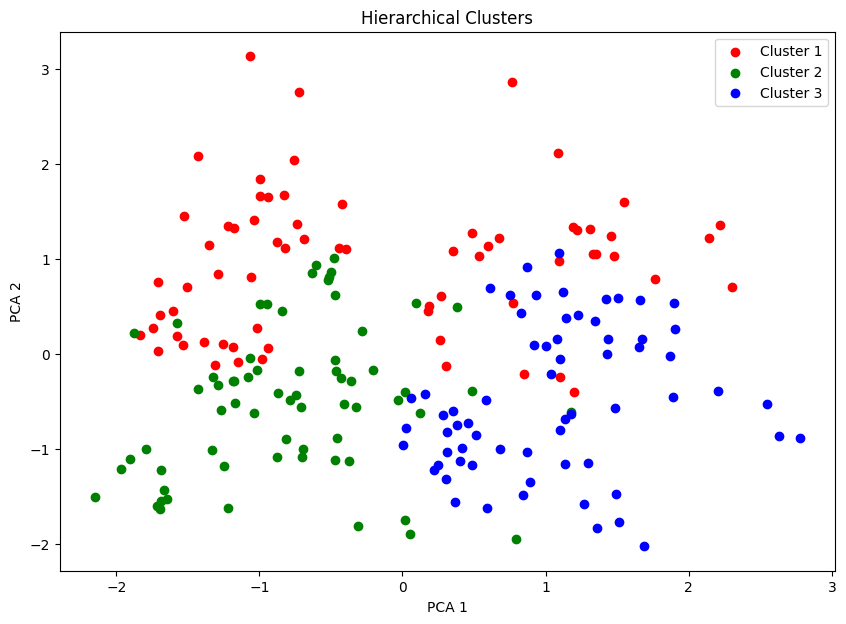

In [20]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

# Reduce to 2 dimensions using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(proc_df)

# Create a scatter plot of the clusters
plt.figure(figsize=(10, 7))
colors = ListedColormap(['red', 'green', 'blue'])

for i, color in enumerate(colors.colors):
    plt.scatter(X_pca[y_hc == i, 0], X_pca[y_hc == i, 1], c=color, label=f'Cluster {i+1}')

plt.title('Hierarchical Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend()
plt.show()

## Task 4: Mean-Shift Clustering

(a) Perform mean-shift clustering on the data. (In R you can use the MeanShiftR package.)

(b) How many clusters do you detect?

(c) Are the cluster assignments different from the results obtained with the previous two methods? How can you evaluate this?

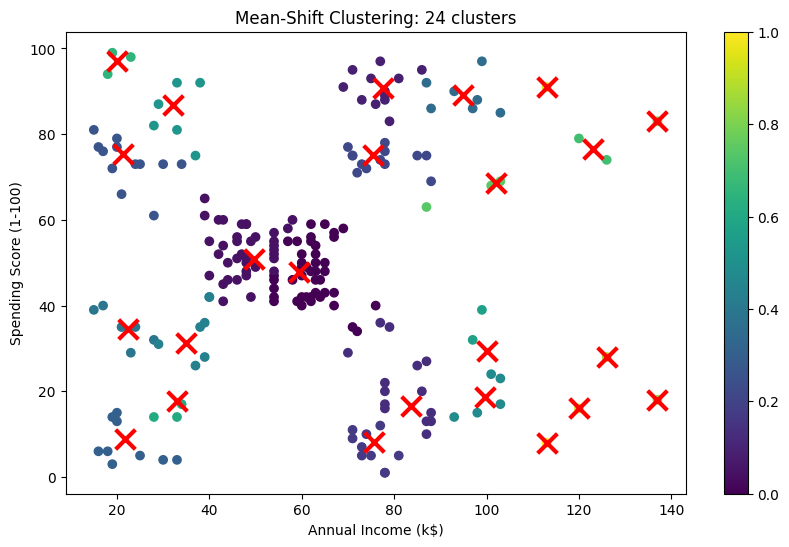

In [21]:
# Mean Shift Clustering

from sklearn.cluster import MeanShift
import numpy as np

# Prepare the data
X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

# Perform Mean-Shift clustering
ms = MeanShift(bandwidth=10)
ms.fit(X)

# Get cluster labels and centers
labels = ms.labels_
cluster_centers = ms.cluster_centers_

# Number of clusters
n_clusters = len(np.unique(labels))

# Visualize the results
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis')
plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], marker='x', s=200, linewidths=3, color='r')
plt.title(f'Mean-Shift Clustering: {n_clusters} clusters')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending Score (1-100)')
plt.colorbar()
plt.show()

(b) How many clusters do you detect?

24 clusters

In [38]:
from sklearn.cluster import MeanShift, KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn.metrics import confusion_matrix

X = df[['Annual Income (k$)', 'Spending Score (1-100)']].values

# 1. Mean-Shift Clustering
ms = MeanShift(bandwidth=10)
ms.fit(X)
ms_labels = ms.labels_

# 2. K-Means Clustering
kmeans = KMeans(n_clusters=2, random_state=6)
kmeans.fit(X)
kmeans_labels = kmeans.labels_

hierarchical = AgglomerativeClustering(n_clusters=3)
hierarchical_labels = hierarchical.fit_predict(X)

# Number of clusters
print(f"Mean-Shift clusters: {len(np.unique(ms_labels))}")
print(f"K-Means clusters: {len(np.unique(kmeans_labels))}")
print(f"Hierarchical clusters: {len(np.unique(hierarchical_labels))}")



Mean-Shift clusters: 24
K-Means clusters: 2
Hierarchical clusters: 3


Mean-Shift Clustering identified 24 clusters, significantly higher than K-Means (2 clusters) and Hierarchical Clustering (3 clusters). This difference suggests that Mean-Shift is sensitive to smaller data groupings, likely capturing more nuanced sub-clusters.

K-Means and Hierarchical Clustering found fewer clusters, indicating a preference for broader, more generalized groupings in the dataset.

In [39]:

# 4. Adjusted Rand Index (ARI)
ari_kmeans_ms = adjusted_rand_score(ms_labels, kmeans_labels)
ari_hierarchical_ms = adjusted_rand_score(ms_labels, hierarchical_labels)
print(f"Adjusted Rand Index between Mean-Shift and K-Means: {ari_kmeans_ms}")
print(f"Adjusted Rand Index between Mean-Shift and Hierarchical: {ari_hierarchical_ms}")


Adjusted Rand Index between Mean-Shift and K-Means: 0.09101715722727134
Adjusted Rand Index between Mean-Shift and Hierarchical: 0.21611620856468228


Mean-Shift vs. K-Means: The ARI score of 0.091 indicates very low similarity between the cluster assignments of Mean-Shift and K-Means, reflecting the substantial difference in cluster numbers and structure.

Mean-Shift vs. Hierarchical Clustering: With an ARI of 0.216, Mean-Shift and Hierarchical Clustering have slightly more similarity than with K-Means but still show limited alignment in clustering outcomes. This difference could be due to the larger number of clusters identified by Mean-Shift.

In [40]:
# 5. Silhouette Score for each method
silhouette_ms = silhouette_score(X, ms_labels)
silhouette_kmeans = silhouette_score(X, kmeans_labels)
silhouette_hierarchical = silhouette_score(X, hierarchical_labels)
print(f"Silhouette Score for Mean-Shift: {silhouette_ms}")
print(f"Silhouette Score for K-Means: {silhouette_kmeans}")
print(f"Silhouette Score for Hierarchical Clustering: {silhouette_hierarchical}")



Silhouette Score for Mean-Shift: 0.38359672248282123
Silhouette Score for K-Means: 0.3018388842973137
Silhouette Score for Hierarchical Clustering: 0.4618340266628975


**Mean-Shift**: The silhouette score of 0.384 indicates moderate clustering quality, suggesting that some data points are closer to other clusters than their own.

**K-Means**: With a score of 0.302, K-Means clustering has the lowest silhouette score, implying less-defined clusters with greater overlap between groups.

**Hierarchical Clustering**: The highest silhouette score of 0.462 suggests that Hierarchical Clustering has the best-defined clusters among the methods, with points more closely associated with their own clusters.

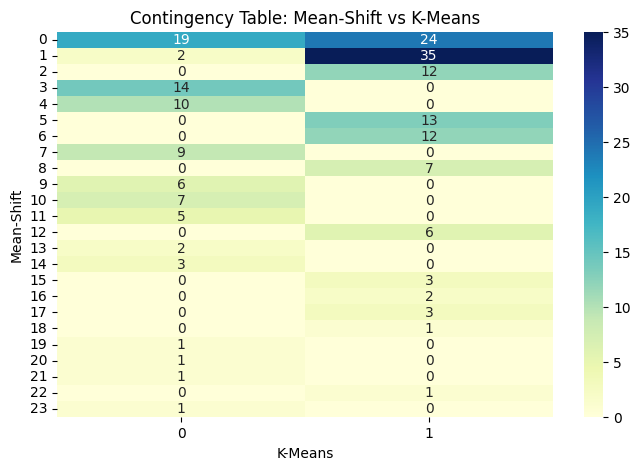

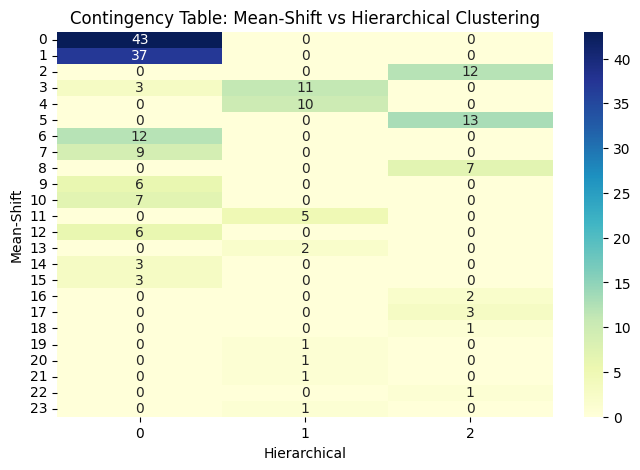

In [41]:
# 6. Contingency Table
contingency_kmeans_ms = pd.crosstab(ms_labels, kmeans_labels, rownames=['Mean-Shift'], colnames=['K-Means'])
contingency_hierarchical_ms = pd.crosstab(ms_labels, hierarchical_labels, rownames=['Mean-Shift'], colnames=['Hierarchical'])

# Plot the contingency tables as heatmaps for visualization
plt.figure(figsize=(8, 5))
sns.heatmap(contingency_kmeans_ms, annot=True, cmap="YlGnBu")
plt.title("Contingency Table: Mean-Shift vs K-Means")
plt.show()

plt.figure(figsize=(8, 5))
sns.heatmap(contingency_hierarchical_ms, annot=True, cmap="YlGnBu")
plt.title("Contingency Table: Mean-Shift vs Hierarchical Clustering")
plt.show()


**Mean-Shift Clustering** captures a large number of small, distinct clusters, which may be useful if highly granular segmentation is required. However, the moderate silhouette score and low ARI scores indicate that these clusters might not be as cohesive or aligned with broader patterns.

**Hierarchical Clustering** provides a more balanced solution with clearer, well-separated clusters, as shown by its higher silhouette score and slightly higher ARI with Mean-Shift.

**K-Means Clustering** seems to overgeneralize with only two clusters, yielding the lowest silhouette score and showing the least alignment with Mean-Shift, as seen in the ARI score and contingency table.


____


Hierarchical Clustering seems like the most suitable approach due to its well-defined clusters and reasonable balance between generalization and specificity.






